__Statistical Learning in High Dimension__
<br>_Professor: M. Hebiri_
<br>_Students: M. Berezov, V. Oliinyk_
### TP2. Projection estimation
_In this practical session we are studying projection estimation and the role the smoothing parameter N (the number of the first functions of the basis in our functional space) plays._

#### Exercise 1. Fourier
1.1 _Data simulation_
<br> We simulate a sample of 100 couples of independent variables $(X_i, Y_i), i = 1,...,n$, where
i.i.d. $X_i$ is coming from standard uniform distribution, and $Y_i$: $$Y_i = f(X_i) + \sigma \xi_i,$$ where $f(x) = x^2 2^{x-1}-(x-0.5)^3 sin(10x), \sigma = 0.2, \xi_i  \sim N(0,1)$, i.i.d.
<br>We observe $X_i$ and $Y_i, i=1,...,n$

In [1]:
import numpy as np
n = 100
X = np.random.uniform(0, 1, 100)
def f(x):
    return ((x**2)*(2**(x-1))-(x-0.5)**3)*np.sin(10*x)
sigma = 0.2
Ksi = np.random.normal(0, 1, 100)
Y = f(X) + sigma*Ksi

Let's take a look at the observations (in blue dots) and the underlying $f(x)$ function (red line).

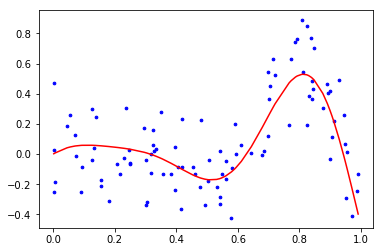

In [2]:
import matplotlib.pyplot as plt
ind_ord = X.argsort()
X = X[ind_ord]
Y = Y[ind_ord]
plt.plot(X, Y, 'bo', ms=2.7)
plt.plot(X, f(X), '-r')
plt.show()

<br> We can think of $Y$ as a noisy version of the function $f(X)$.

<br>
Our goal is to build a projection estimator of the function $f$ using the observed data $\{X_i, Y_i\}, i=1,...,n$. 
<br>We will build first $N$ functions from an orthonormal Fourier basis $\{\varphi_{j}\}_{j=1}^{N}$ and approximate $f$ by its projection on their linear span: $\sum_{j=1}^{N}\theta_j\varphi_j$. We will replace coefficients $\theta_j$ by their estimators. 

<br> _Fourier basis_
<br> An orthonormal basis in $L_2 [0,1]$ defined by
$$ \varphi_1(x) \equiv 1,$$
$$ \varphi_{2j}(x) = \sqrt{2}cos(2\pi jx)$$
$$ \varphi_{2j+1}(x) = \sqrt{2}cos(2\pi jx)$$ 
$$ j = 1, 2,...$$
Let's look at the first 5 funcitons of this basis. 

In [3]:
# Fourier basis
def phi (j, x):
    if j==1:
        return np.ones(len(x))
    elif (j%2==0):
        return np.sqrt(2)*np.cos(np.pi*j*x)
    else:
        return np.sqrt(2)*np.sin(np.pi*(j-1)*x)

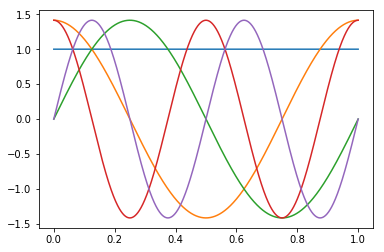

In [4]:
grid_x = np.linspace(0, 1, num = 10**4)
for j in np.arange(5)+1:
    plt.plot(grid_x, phi(j, grid_x), '-')
plt.show()

Functions of Fourier basis are periodic, and this implies that it would be a good idea to project non-linear periodic functions on such a basis.

As menitoned, above, we buid a projection estimator in the following way: 
$$ \hat{f}_{n, N}(x) = \sum_{j=1}^{N}\hat{\theta_j}\varphi_j(x),$$
where $$\hat{\theta_j}=\frac{1}{n}\sum_{i=1}^{n}Y_i\varphi_j(X_i)$$
Notice that $n$ is a size of our sample and $N$ is a number of first functions in the Fourier basis, $n > N$.
<br> We also notice that $X_i$ is uniformly distributed over [0,1]; hence, as discussed during the lecture, the true coefficients $\theta$ are well approximated by $\hat{\theta}$.

<br> Below, we plot the obseved $\{X_i, Y_i\}$, ground-truth function $f$ and its projection estimator $\hat{f}_N$ for different values of smoothing parameter $N = \{5, 10, 15, 20, 30, 50, 70\}$.

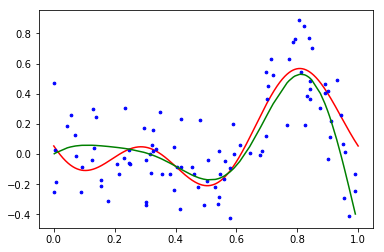

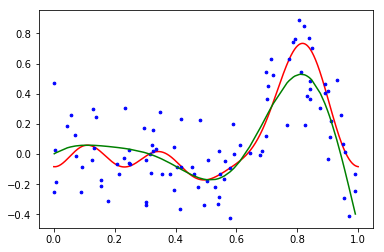

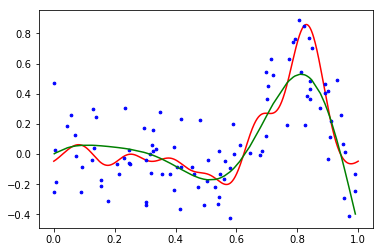

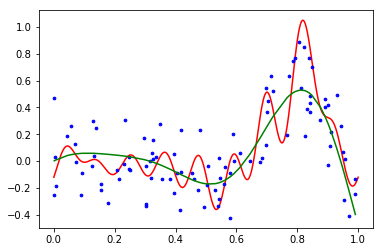

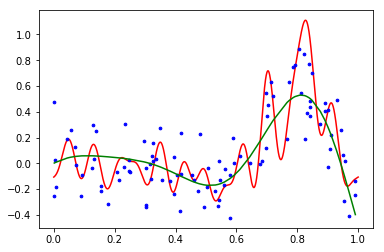

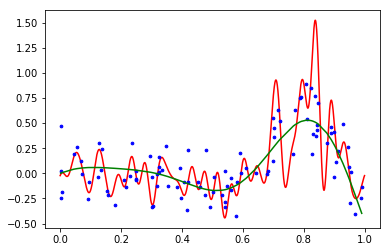

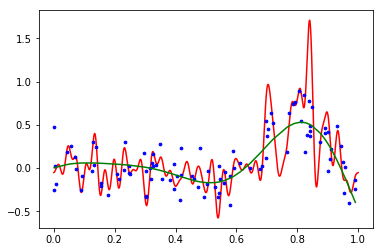

In [5]:
Ns = [5, 10, 15, 20, 30, 50, 70]
# Projection estimator
# Calculate the Fourier coefficients:
def theta(X, Y, j):
    Theta = Y*phi(j, X)
    return np.mean(Theta)
# Build projection estimator:
def f_hat(N, x, X, Y):
    F = np.array([theta(X, Y, j)*phi(j, x) for j in np.arange(N)+1])
    return np.sum(F, axis=0)
# Plot projection estimators, observation and true f for different N
for N in Ns:
    fN_hat = f_hat(N, grid_x, X, Y)
    plt.plot(grid_x, fN_hat,'-r')
    plt.plot(X, Y, 'bo', ms=2.7)
    plt.plot(X, f(X), '-g')
    plt.show()

As the plots above show, it is a bad idea to use more than 20 first functions of the basis in the estimator $\hat{f}$. In this case, the function $\hat{f}$ becomes very oscillating leading to strong overfitting.
<br> By eye, we estimate the optimal number of basis functions to be around 5-10. 
<br> We want to use a more systematic approach, namely, cross-validation to estimate the optimal number $N$.

<br> _Cross-validation_
<br> We split sample $\{X_i, Y_i\}$ into $V$ folds (nearly equally sized), and for different values of $N$ we calculate _cross-validation error_, $\epsilon_{CV}(N)$. 
<br>For every fold $B_v$ we train the estimator on the resting data, getting $\hat{f}^{-v}(x)$ and test it on this fold, calculating $\epsilon_v=\frac{1}{\#(B_v)}\sum_{i=1}^{n}(\hat{f}^{-v}(X_i)-Y_i)^2$. Averaging errors on all folds, we get cross-validation error: $\epsilon_{CV}(N)=\frac{1}{V}\sum_{v=1}{V}\epsilon_v$. We choose the model delivering the minimal cross-validation error.

<br> We have chosen the number of folds to be 10. This is a classical practice.

In [6]:
# Calculate error on fold B_v
def err_Bv(N, v, V, X, Y):
    train_ind = [i for i, x in enumerate(X) if i % V != v]
    valid_ind = [i for i, x in enumerate(X) if i % V == v]
    f_v = f_hat(N, X[valid_ind], X[train_ind], Y[train_ind])
    return np.mean((f_v - Y[valid_ind])**2)

In [7]:
# Calculate cross-validation error
def err_cv(N, V, X, Y):
    err_l = np.array([err_Bv(N, v, V, X, Y) for v in np.arange(V)])
    return np.mean(err_l)

Optimal N is: 5


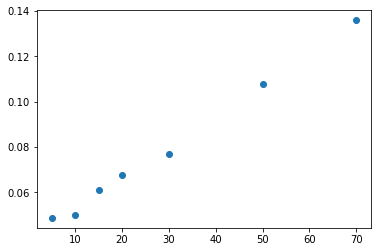

In [8]:
V = 10
errors = [err_cv(N, V, X, Y) for N in Ns]
N_opt = Ns[np.argmin(errors)]
print("Optimal N is: " + str(N_opt))
plt.plot(Ns, errors,'o')
plt.show()

For this specific sample the optimal smoothing parameter $N_{CV}$ turned out to equal 5. This corresponds to our intuition and the assumption we made observing the plots.

However, clearly, the optimal $N_{CV}$ depends on the realizations of $X$ and $\xi$, hence is a random number. We conduct an experiment simulating samples of $X$ and $\xi$ 200 times and calculate $N_{CV}$ for each simulation. Finally, we plot a histogram of $N_{CV}$.

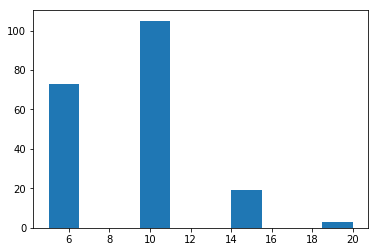

In [10]:
def Ns_opt (V):
    X = np.random.uniform(0, 1, 100)
    Ksi = np.random.normal(0, 1, 100)
    Y = f(X) + sigma*Ksi
    errors = [err_cv(N, V, X, Y) for N in Ns]
    N_opt = Ns[np.argmin(errors)]
    return N_opt
V = 50
Ns_opt = np.array([Ns_opt(V) for i in np.arange(200)])
plt.hist(Ns_opt)
plt.show()

As the resulting histogram shows, the optimal $N_{CV}$ are concentrated around 10. During this simulation $N$ never happened to be larger than 20. 

<br> It's interesiting to look closer at the values of $N$ from 2 to 13.
Let's examine them.